# TOPIC MODELING

#### TEXT MINING AND SEARCH

*Master Degree in Data Science* <br>
*University of Milano-Bicocca* <br> <br>

 Marta Brasola, Andrea Malinverno, Mattia Proserpio



In this notebook we are dealing with the processing and exploration task of the project. We will use the dataframe **song_processed** as the input for the 2 tasks:

1. Text Classification
2. Topic Modeling



1.  [Text Processing](#first-bullet)
  1. regex
  2. tokenization
  3. pos_tagging
  4. lemmatization
2. [Text Exploration](#second-bullet)
3. [Rhyme Analysis](#third-bullet)


In [ ]:
!pip install pronouncing
!pip install symspellpy

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.4/939.4 kB 7.4 MB/s eta 0:00:00
  Created wheel for pronouncing: filename=pronouncing-0.2.0-py2.py3-none-any.whl size=6234 sha256=5aaab9107700ea6bde5a4b74b7c2533ca7fc377bfdb20b853a4ec2697412d696
  Stored in directory: /root/.cache/pip/wheels/05/f6/1d/599c67da1fa48c086d8c49e8fc6bd5f05bc9fa66fb04bed5db
Successfully built pronouncing
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.2/57.2 kB 6.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for editdistpy: filename=editdistpy-0.1.3-cp310-cp310-linux_x86_64.whl size=187457 sha256=da51a65de231612041356b257488751e199770a5dfc42375dcbfd8f9190e591f
  Stored in directory: /root/.cache/pip/wheels/88/6a/a6/a1283cc145323a1fb3d475bd158ee60b248ab1985230d266fc
Succe

In [ ]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
# from itertools import cycle
from tabulate import tabulate
import itertools
from pprint import pprint

from gensim import models
from gensim.utils import ClippedCorpus
from gensim.corpora.dictionary import Dictionary
import gensim
from tqdm import tqdm

from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer

from sklearn.utils.extmath import randomized_svd
from symspellpy import SymSpell, Verbosity
import pkg_resources
import pronouncing
from pronouncing import rhymes

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('tagsets')
nltk.download('universal_tagset')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package tagsets to /root/nltk_data...
[nltk_data]   Unzipping help/tagsets.zip.
[nltk_data] Downloading package universal_tagset to /root/nltk_data...
[nltk_data]   Unzipping taggers/universal_tagset.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
custom_params = {
    "axes.spines.right": False,
    "axes.spines.top": False,
    "axes.grid": True,         # Enable grid
    "grid.color": "gray",  # Set grid color to light gray
    "grid.linestyle": "--",     # Set grid line style to dashed
    "grid.linewidth": 0.5,      # Set grid line width
    "figure.facecolor": "#fbfbfb",
    "axes.facecolor": "#fbfbfb"
}

sns.set_theme(style="ticks", rc=custom_params)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/songs_final.csv')

In [ ]:
df.drop(columns=['artist', 'views', 'features', 'id', 'language_cld3', 'language_ft', 'language'], inplace=True)

In [ ]:
import warnings

# Ignore all FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)


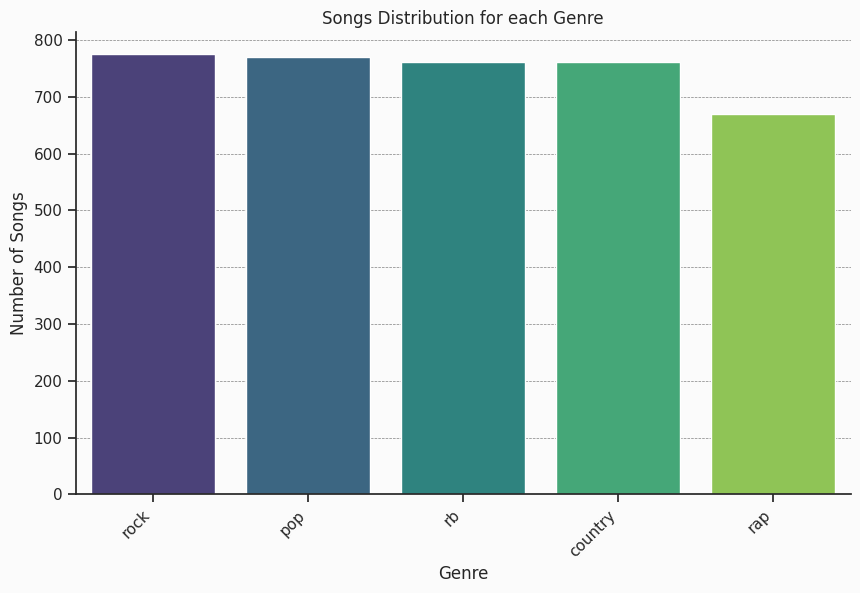

In [ ]:
count_per_genre = df['tag'].value_counts()

# Crea un grafico a barre
plt.figure(figsize=(10, 6))
sns.barplot(x=count_per_genre.index, y=count_per_genre.values, palette='viridis')
plt.title('Songs Distribution for each Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Songs')
plt.xticks(rotation=45, ha='right')
plt.show()

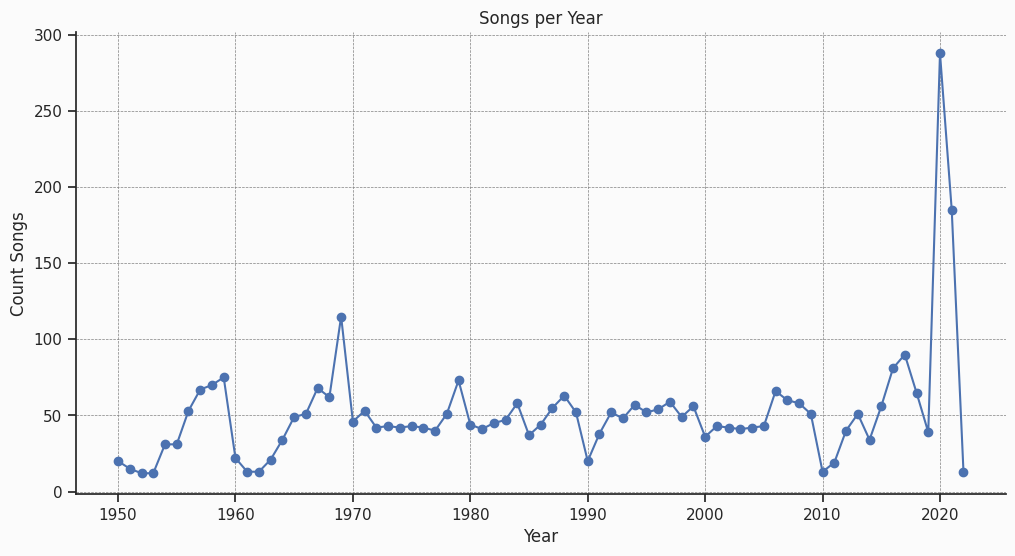

In [ ]:
plt.figure(figsize=(12, 6))
df['year'].value_counts().sort_index().plot(kind='line', marker='o')
plt.title('Songs per Year')
plt.xlabel('Year')
plt.ylabel('Count Songs')
plt.show()

In [ ]:
sns.set_palette('tab20')

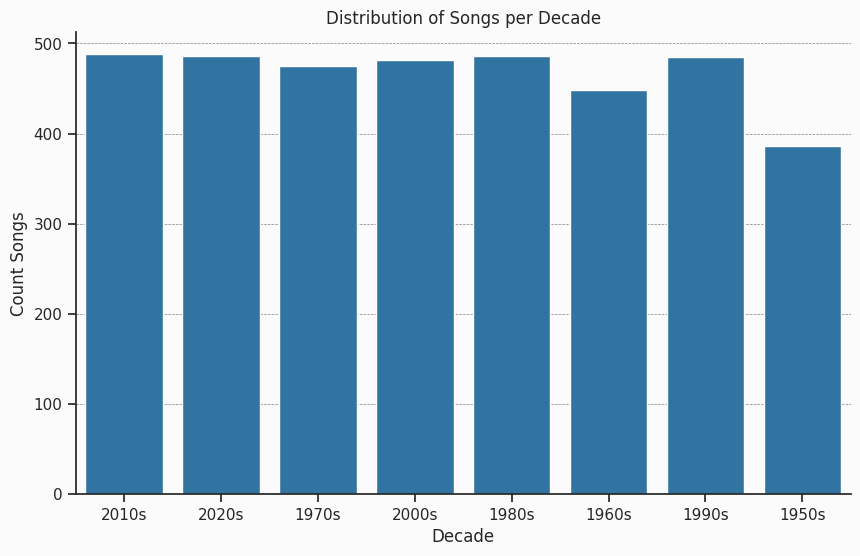

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(x='decade', data=df)
plt.xlabel('Decade')
plt.ylabel('Count Songs')
plt.title('Distribution of Songs per Decade')
plt.show()

## Text Processing <a name="first-bullet"></a>

In [ ]:
df.columns = ['title', 'tag', 'year', 'raw_lyrics', 'decade']
df.head()

title  tag  year                                         raw_lyrics  \
0       Rap God  rap  2013  [Intro]\n"Look, I was gonna go easy on you not...   
1           WAP  rap  2020  [Intro: Cardi B, Al "T" McLaran & Megan Thee S...   
2  Shape of You  pop  2017  [Verse 1]\nThe club isn't the best place to fi...   
3       HUMBLE.  rap  2017  [Intro]\nNobody pray for me\nIt been that day ...   
4     The Hills   rb  2015  [Intro]\nYeah\nYeah\nYeah\n\n[Verse 1]\nYour m...   

  decade  
0  2010s  
1  2020s  
2  2010s  
3  2010s  
4  2010s

In [ ]:
df.shape

(3736, 5)

In [ ]:
def clean_text(text):
    # remove punctuation
    text = re.sub(r'[,;\.!?-]', '', text)
    # removing text in square brackets
    text = re.sub(r'\[.*?\]', '', text)
    # removing numbers
    text = re.sub(r'\w*\d\w*', '', text)
    # removing brackets
    text = re.sub(r'[()]', '', text)
    # remove forward slash
    text = text.replace('/', '')
    # remove asterisk
    text = text.replace('*', '')
    text = re.sub(r'"', '', text)
    text = re.sub(r"'", '', text)
    # replace '—' with an empty string
    text = text.replace('—', '')
    text = text.replace('’', '')
    # convert all words to lowercase
    text = text.lower()
    return text

df['norm_lyrics'] = df['raw_lyrics'].apply(clean_text)

In [ ]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    return tokens

df['norm_lyrics'] = df['norm_lyrics'].replace('\n', '')
df['norm_lyrics'] = df['norm_lyrics'].apply(tokenize)

In [ ]:
# Function to perform lemmatization and remove stop words
def lemmatize_and_remove_stopwords(tokens):
    lemmatizer = WordNetLemmatizer()
    stop_words = set(stopwords.words('english'))
    stop_words.update(['oh', 'hey', 'ya', 'uh', 'huh', 'ooh', 'ah', 'yeah', 'na', 'yeah yeah'])

    # Perform lemmatization with pos_tag
    pos_tags = pos_tag(tokens)
    lemmatized = [lemmatizer.lemmatize(word, pos=get_wordnet_pos(tag)) for word, tag in pos_tags]

    # Remove stop words
    lemm_no_stop = [word for word in lemmatized if word.lower() not in stop_words]

    return lemm_no_stop

# Function to get WordNet POS tag
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n'

# Apply the lemmatize_and_remove_stopwords function to the 'norm_lyrics' column
df['lemm_no_stop'] = df['norm_lyrics'].apply(lemmatize_and_remove_stopwords)


In [ ]:
def remove_stop_words(tokens):

    stop_words = set(stopwords.words('english'))
    stop_words.update(['oh', 'hey', 'ya', 'uh', 'huh', 'ooh', 'ah', 'yeah', 'na', 'yeah yeah'])
    no_stop = [word for word in tokens if word.lower() not in stop_words]
    return no_stop

In [ ]:
df['no_stop'] = df['norm_lyrics'].apply(remove_stop_words)

## Text Exploration <a name="second-bullet"></a>

In [ ]:
# Function to calculate word statistics
def calculate_word_statistics(column):
    total_words = []
    unique_words = []

    for tokens in column:
        # Update total words count
        total_words.extend(tokens)

        # Update unique words count
        unique_words.extend(set(tokens))

    # Calculate statistics
    total_words_count = len(total_words)
    avg_words_per_song = total_words_count / len(column)

    unique_words_count = len(set(unique_words))
    avg_unique_words_per_song = unique_words_count / len(column)

    return total_words_count, avg_words_per_song, unique_words_count, avg_unique_words_per_song

# Calculate statistics for 'norm_lyrics' column
norm_lyrics_stats = calculate_word_statistics(df['norm_lyrics'])

# Calculate statistics for 'lemm_no_stop' column
lemm_no_stop_stats = calculate_word_statistics(df['lemm_no_stop'])

no_stop_stats = calculate_word_statistics(df['no_stop'])

In [ ]:

table = [
    ["", "Total Words Count", "Avg Words per Song", "Unique Words Total", "Avg Unique Words per Song"],
    ["norm_lyrics", norm_lyrics_stats[0], norm_lyrics_stats[1], norm_lyrics_stats[2], norm_lyrics_stats[3]],
    ["no_stop", no_stop_stats[0], no_stop_stats[1], no_stop_stats[2], no_stop_stats[3]],
    ["lemm_no_stop", lemm_no_stop_stats[0], lemm_no_stop_stats[1], lemm_no_stop_stats[2], lemm_no_stop_stats[3]]
]

print(tabulate(table, headers="firstrow", tablefmt="fancy_grid"))

╒══════════════╤═════════════════════╤══════════════════════╤══════════════════════╤═════════════════════════════╕
│              │   Total Words Count │   Avg Words per Song │   Unique Words Total │   Avg Unique Words per Song │
╞══════════════╪═════════════════════╪══════════════════════╪══════════════════════╪═════════════════════════════╡
│ norm_lyrics  │             1387318 │              371.338 │                31348 │                     8.39079 │
├──────────────┼─────────────────────┼──────────────────────┼──────────────────────┼─────────────────────────────┤
│ no_stop      │              723647 │              193.696 │                31201 │                     8.35145 │
├──────────────┼─────────────────────┼──────────────────────┼──────────────────────┼─────────────────────────────┤
│ lemm_no_stop │              720600 │              192.88  │                26233 │                     7.02168 │
╘══════════════╧═════════════════════╧══════════════════════╧═══════════════════

In [ ]:
df['lemm_no_stop'].head()

0    [look, gon, go, easy, hurt, feeling, im, go, g...
1    [whore, house, theres, whore, house, theres, w...
2    [club, isnt, best, place, find, lover, bar, go...
3    [nobody, pray, day, way, ayy, remember, syrup,...
4    [man, road, doin, promo, say, keep, business, ...
Name: lemm_no_stop, dtype: object

### Plots

#### Plot TF-IDF in respect to labels

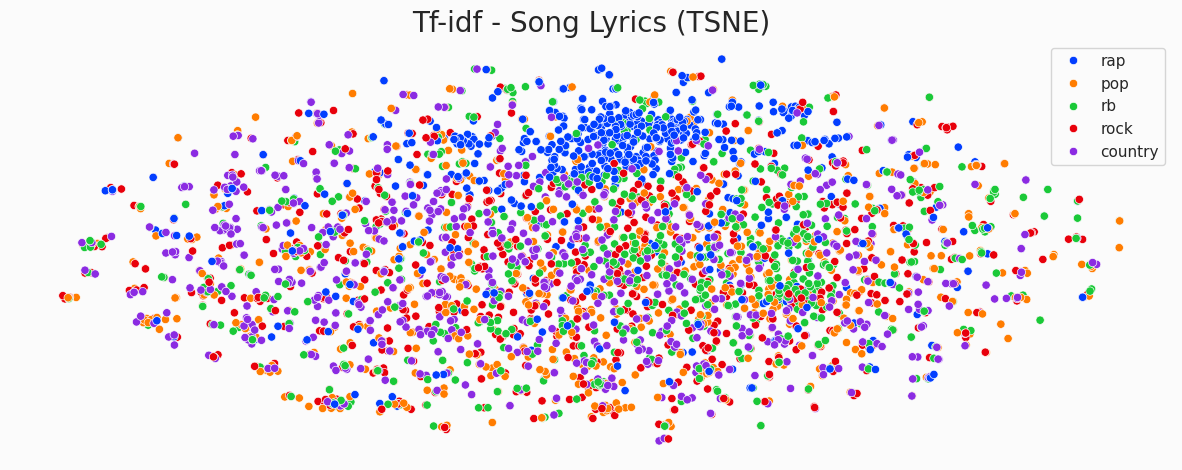

In [ ]:
labels = df['tag'].values
tfidf_vectorizer = TfidfVectorizer(max_features=1200)
documents = [' '.join(words) for words in df['lemm_no_stop']]
tfidf = tfidf_vectorizer.fit_transform(documents)


# Plotting TF-IDF
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)

tsne = TSNE(n_components=2, random_state=42)
data_tsne = tsne.fit_transform(tfidf.toarray())
scatter_x = data_tsne[:, 0]
scatter_y = data_tsne[:, 1]
sns.scatterplot(x=scatter_x, y=scatter_y, hue=labels, palette='bright', legend=True)
plt.title("Tf-idf - Song Lyrics (TSNE)", fontsize=20)
plt.axis('off')
plt.show()

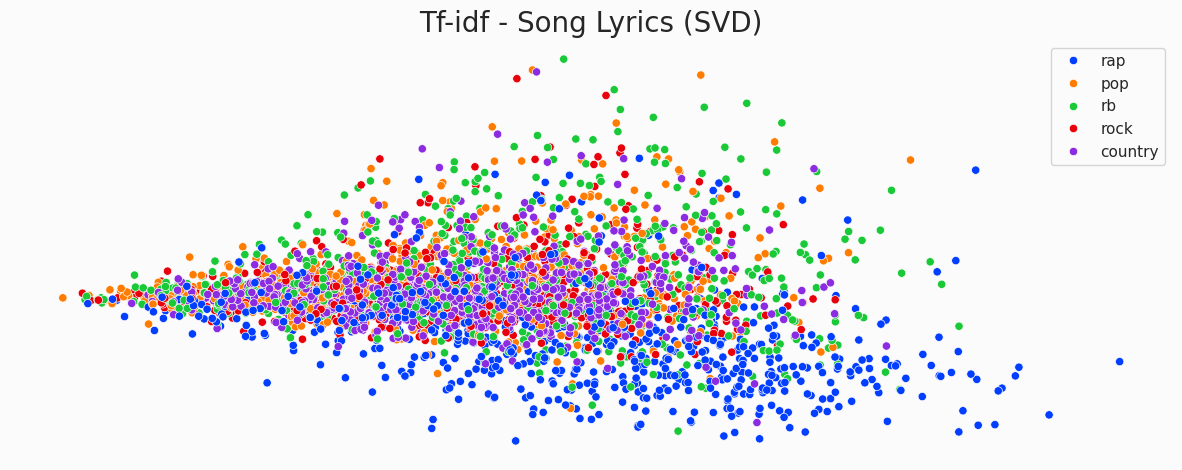

In [ ]:
labels = df['tag'].values
tfidf_vectorizer = TfidfVectorizer(max_features=1200)
documents = [' '.join(words) for words in df['lemm_no_stop']]
tfidf = tfidf_vectorizer.fit_transform(documents)


# Plotting TF-IDF
plt.figure(figsize=(15, 12))
plt.subplot(2, 1, 1)
svd = TruncatedSVD(n_components=2)
data = svd.fit_transform(tfidf)
scatter_x = data[:, 0]
scatter_y = data[:, 1]
sns.scatterplot(x=scatter_x, y=scatter_y, hue=labels, palette='bright', legend=True)
plt.title("Tf-idf - Song Lyrics (SVD)", fontsize=20)
plt.axis('off')
plt.show()

#### World Cloud whole dataset

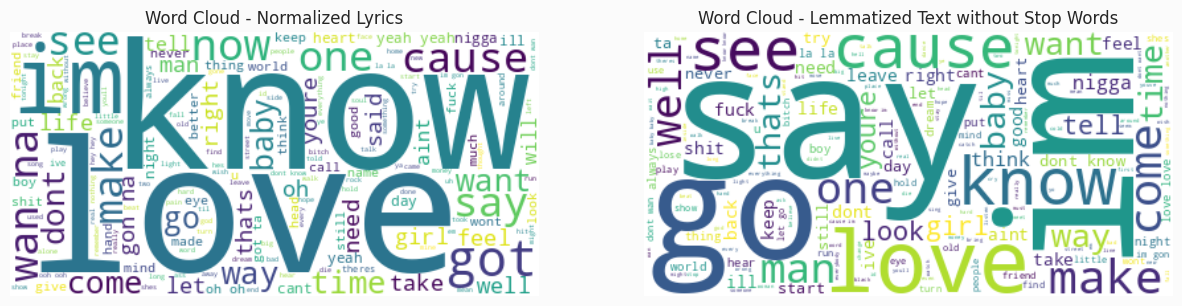

In [ ]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot word cloud for 'norm_lyrics' column
text_norm_lyrics = ' '.join(df['norm_lyrics'].astype(str))
text_norm_lyrics = re.sub(r'[^a-zA-Z\s]', '', text_norm_lyrics)
wordcloud_norm_lyrics = WordCloud(width=400, height=200, max_words=200, background_color='white').generate(text_norm_lyrics)
axes[0].imshow(wordcloud_norm_lyrics, interpolation='bilinear')
axes[0].axis('off')
axes[0].set_title("Word Cloud - Normalized Lyrics", fontsize=12)

# Plot word cloud for 'lemm_no_stop' column
text_lemm_no_stop = ' '.join(df['lemm_no_stop'].astype(str))
text_lemm_no_stop = re.sub(r'[^a-zA-Z\s]', '', text_lemm_no_stop)
wordcloud_lemm_no_stop = WordCloud(width=400, height=200, max_words=200, background_color='white').generate(text_lemm_no_stop)
axes[1].imshow(wordcloud_lemm_no_stop, interpolation='bilinear')
axes[1].axis('off')
axes[1].set_title("Word Cloud - Lemmatized Text without Stop Words", fontsize=12)

plt.show()

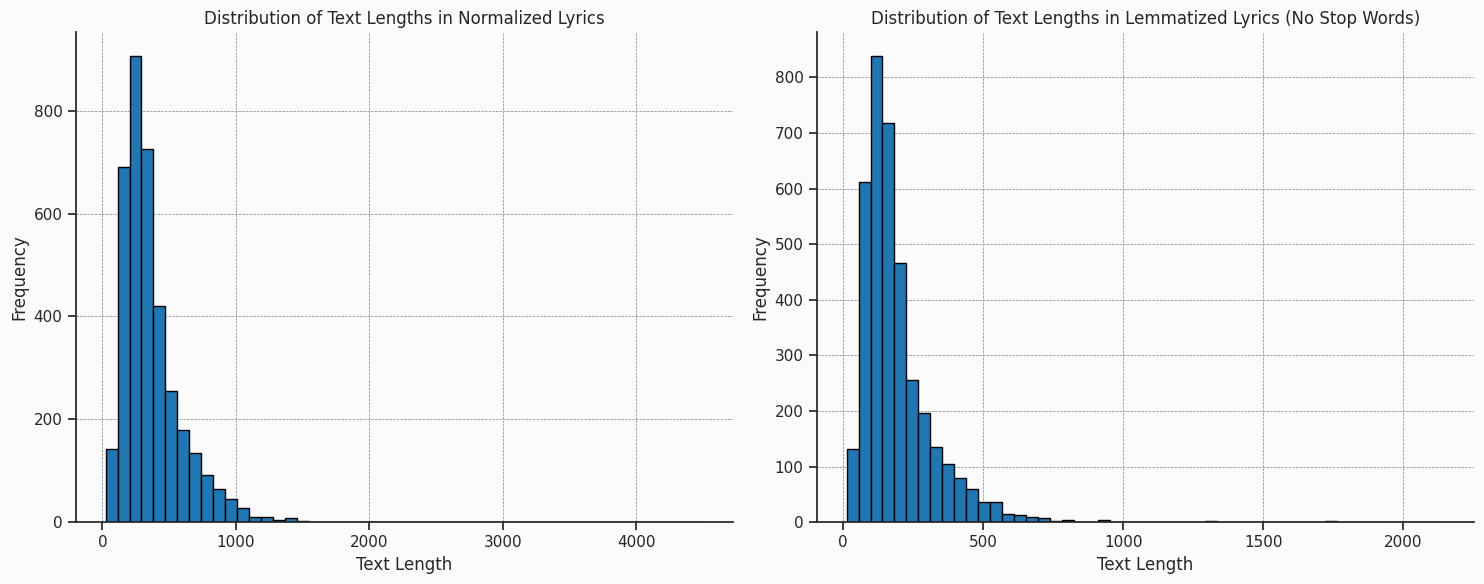

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot histogram for 'norm_lyrics' column (inverted order)
axes[0].hist(df['norm_lyrics'].apply(len), bins=50, edgecolor='black')
axes[0].set_xlabel('Text Length')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Text Lengths in Normalized Lyrics')

# Plot histogram for 'lemm_no_stop' column (inverted order)
axes[1].hist(df['lemm_no_stop'].apply(len), bins=50, edgecolor='black')
axes[1].set_xlabel('Text Length')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Text Lengths in Lemmatized Lyrics (No Stop Words)')
plt.tight_layout()
plt.show()

#### World Cloud based on music Genre

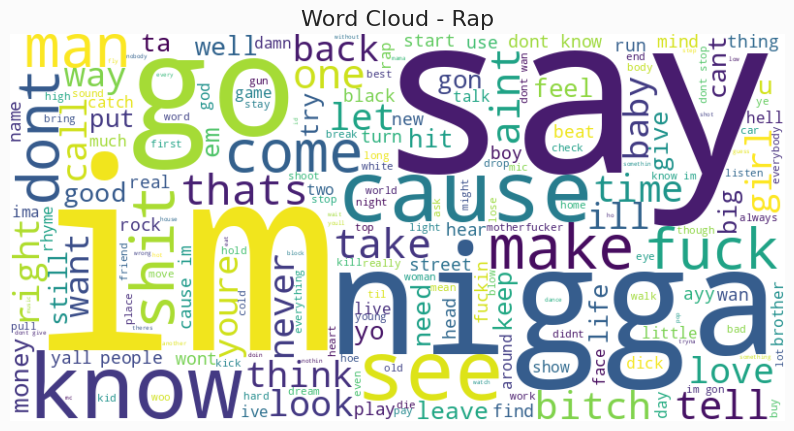

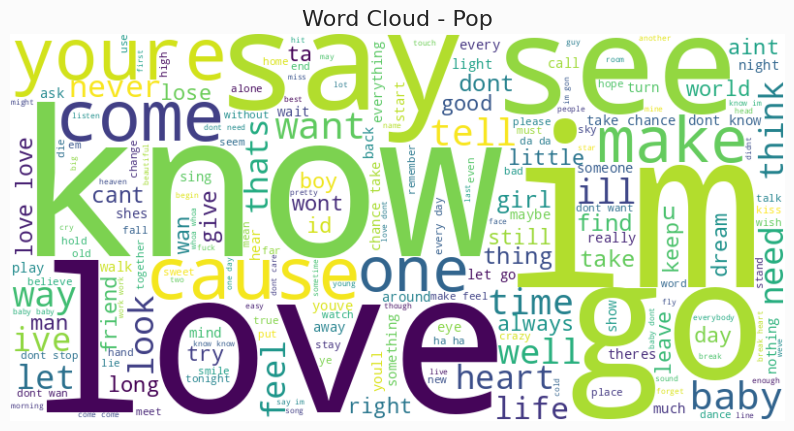

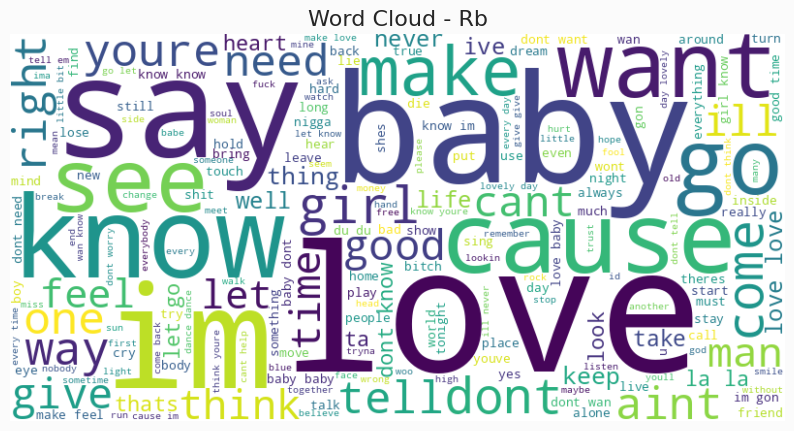

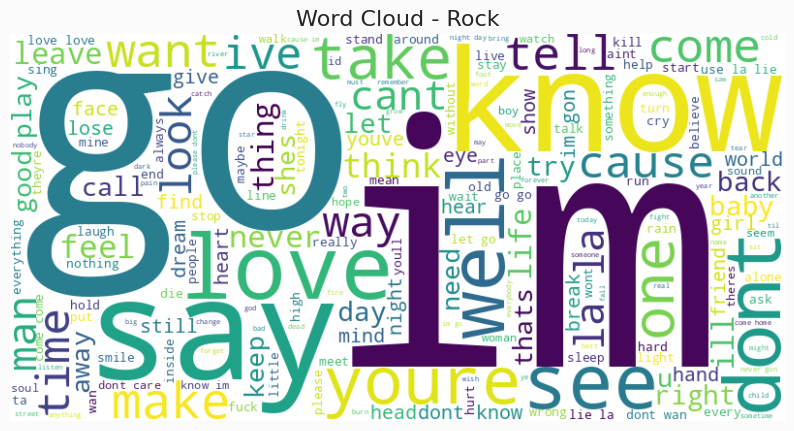

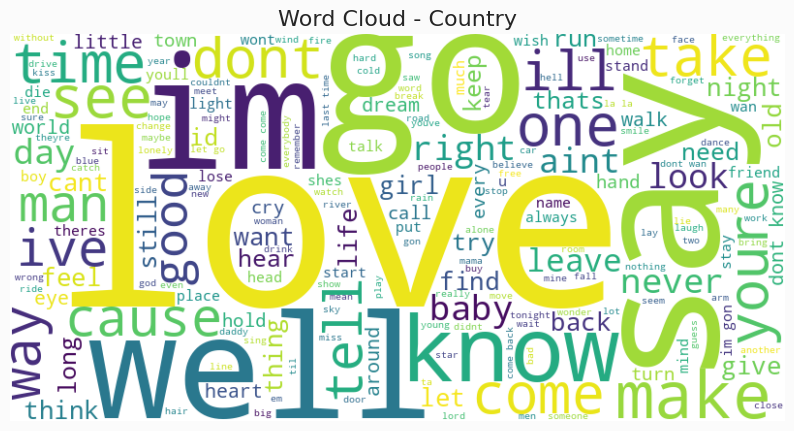

In [ ]:
# Define the list of tags
tags = ['rap', 'pop', 'rb', 'rock', 'country']

# Generate a word cloud for each tag
for tag in tags:
    # Filter DataFrame for the specific tag
    subset_text = ' '.join(df[df['tag'] == tag]['lemm_no_stop'].astype(str))
    subset_text = re.sub(r'[^a-zA-Z\s]', '', subset_text)

    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(subset_text)

    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {tag.capitalize()}", fontsize=16)
    plt.show()

#### Word Cloud for each decade

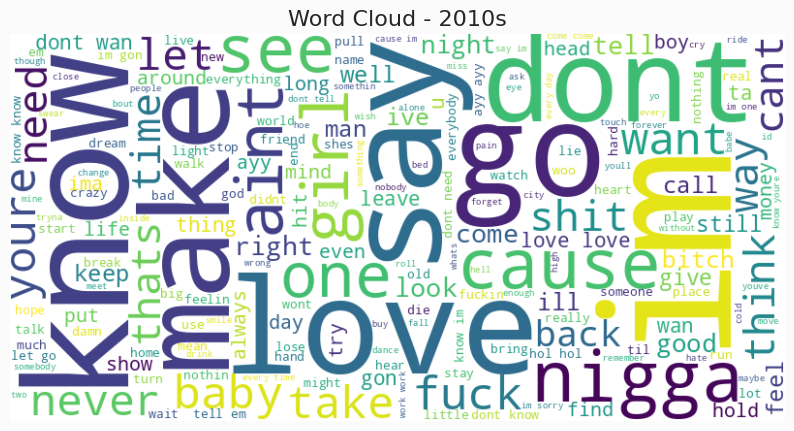

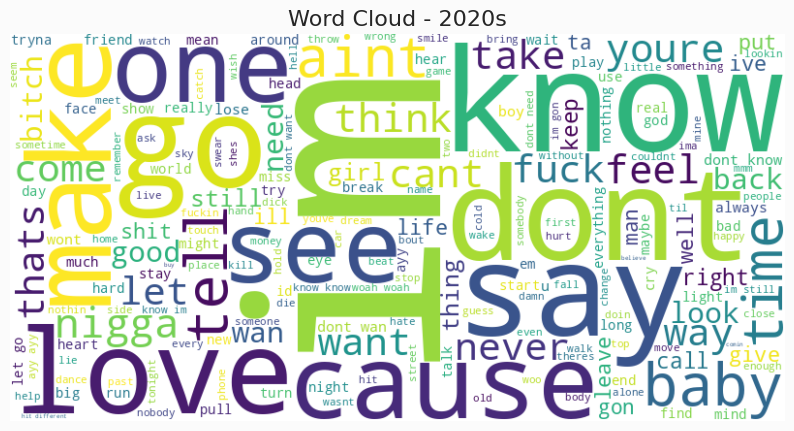

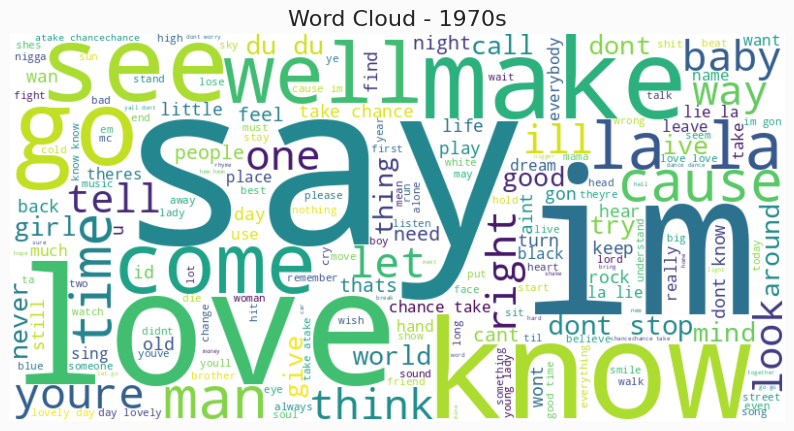

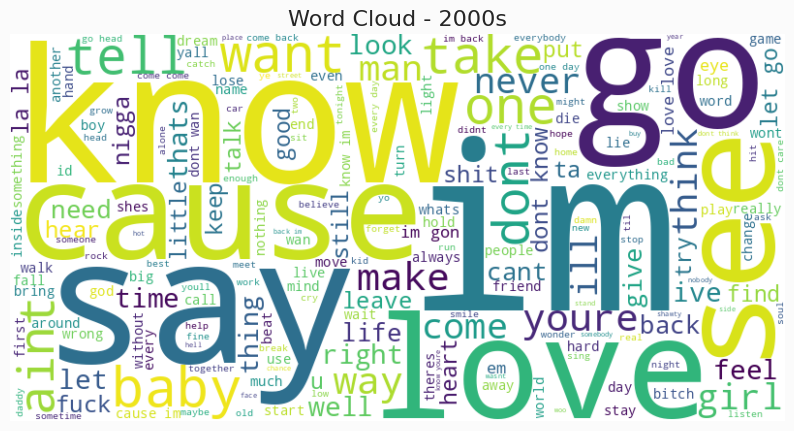

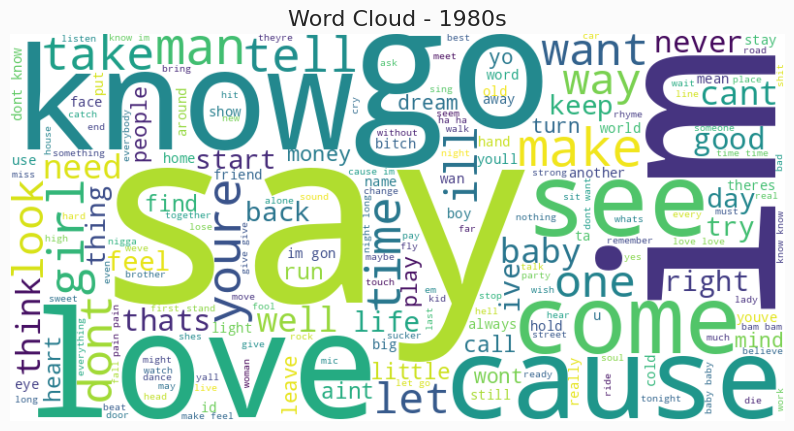

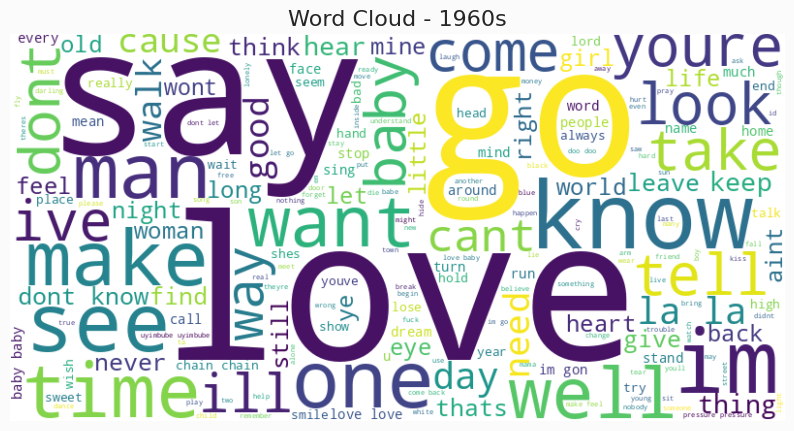

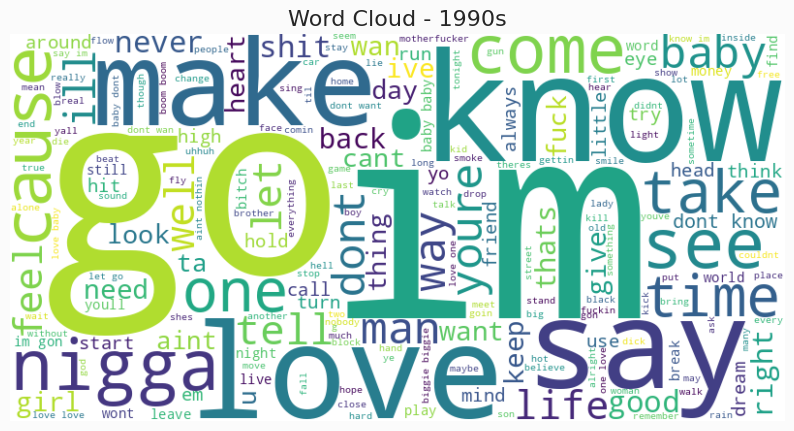

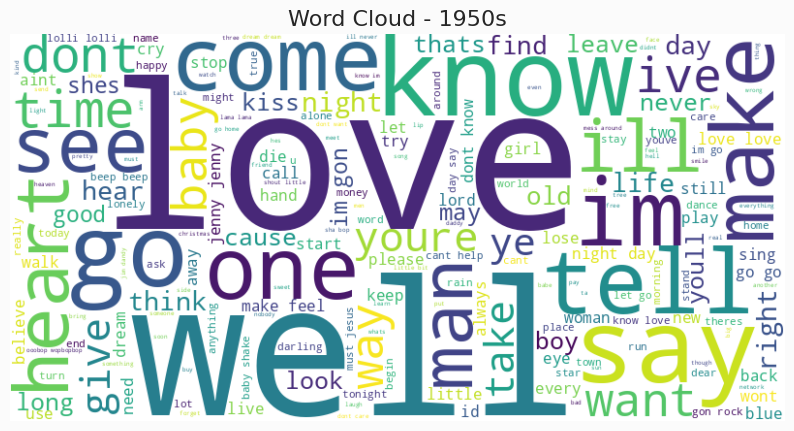

In [ ]:
decades = ['2010s', '2020s', '1970s', '2000s', '1980s', '1960s', '1990s', '1950s']

# Generate a word cloud for each decade
for d in decades:
    # Filter DataFrame for the specific decade
    subset_text = ' '.join(df[df['decade'] == d]['lemm_no_stop'].astype(str))
    subset_text = re.sub(r'[^a-zA-Z\s]', '', subset_text)
    # Generate word cloud
    wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(subset_text)

    # Plot word cloud
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Word Cloud - {d}", fontsize=16)
    plt.show()

## Rhyme Analysis <a name="third-bullet"></a>

In [ ]:
# column that will be useful just for computing rhymes
df['rhyme_lyrics'] = df['raw_lyrics'].apply(clean_text)

In [ ]:
sym_spell = SymSpell()
dictionary_path = pkg_resources.resource_filename(
    "symspellpy", "frequency_dictionary_en_82_765.txt"
)
sym_spell.load_dictionary(dictionary_path, 0, 1)

def get_phones_and_syllables(lyrics):

  senteces = lyrics.split('\n')
  senteces = [line.strip() for line in senteces if line.strip() and line.strip() != '?']

  musical_lines = []

  for i in range(0, len(senteces)):
    musical_line = []

    tokens = word_tokenize(senteces[i])


    for word in tokens:
      phonemes = pronouncing.phones_for_word(word)
      if phonemes == []:
        suggestions = sym_spell.lookup(word, Verbosity.CLOSEST, max_edit_distance=1, include_unknown=True)
        for i in range(0, len(suggestions)):
          if phonemes:
            word = suggestions[i].term
            break

      if phonemes:
        tpl = (word, phonemes[0], pronouncing.syllable_count(phonemes[0]), pronouncing.stresses(phonemes[0]))
        musical_line.append(tpl)
      else:
        tpl = (word, 'UNK', -1, 'UNK')
        musical_line.append(tpl)

    musical_lines.append(musical_line)

  return musical_lines


def get_sublists(list, n):
  return [list[i:i+n] for i in range(len(list)-n+1)]


def check_rhyme(tpl1, tpl2):
  if tpl1[0] == tpl2[0]: return 1
  if tpl1[1] == 'UNK' or tpl2[1] == 'UNK': return 0

  rhyme = 0
  if tpl1[0] in pronouncing.rhymes(tpl2[0]): rhyme = 1
  elif tpl2[0] in pronouncing.rhymes(tpl1[0]): rhyme = 1

  return rhyme


#These functions detect for the presence of a particular 4 line rhyme scheme
def get_rhyme_ABAB(quad_tpl):
    assert len(quad_tpl) == 4, "did not receive list of 4 tuples"
    return check_rhyme(quad_tpl[0], quad_tpl[2]) and check_rhyme(quad_tpl[1],quad_tpl[3])

def get_rhyme_ABBA(quad_tpl):
    assert len(quad_tpl) == 4, "did not receive list of 4 tuples"
    return check_rhyme(quad_tpl[0], quad_tpl[3]) and check_rhyme(quad_tpl[1],quad_tpl[2])

def get_rhyme_AABB(quad_tpl):
    assert len(quad_tpl) == 4, "did not receive list of 4 tuples"
    return check_rhyme(quad_tpl[0], quad_tpl[1]) and check_rhyme(quad_tpl[2],quad_tpl[3])

def get_rhyme_ABAA(quad_tpl):
    assert len(quad_tpl) == 4, "did not receive list of 4 tuples"
    return check_rhyme(quad_tpl[0], quad_tpl[2]) and check_rhyme(quad_tpl[2],quad_tpl[3])

def get_rhyme_AABA(quad_tpl):
    assert len(quad_tpl) == 4, "did not receive list of 4 tuples"
    return check_rhyme(quad_tpl[0], quad_tpl[1]) and check_rhyme(quad_tpl[1],quad_tpl[3])


def get_rhyme_features(musical_data):

    last_words = []
    for line in musical_data:
       last_words.append(line[-1]) #we only care about last tuple of each line

    #Check frequency of rhyming adjacent couplets
    couplets = get_sublists(last_words, 2)
    couplet_rhymes = []
    for couplet in couplets:
        couplet_rhymes.append(check_rhyme(couplet[0], couplet[1]))

    adj_couplet_freq = sum(couplet_rhymes) / len(couplet_rhymes) if len(couplet_rhymes) != 0 else 0

    #Check frequency of rhyming spaced couplets
    triplets = get_sublists(last_words, 3)
    spaced_couplet_rhymes = []
    for triplet in triplets:
        spaced_couplet_rhymes.append(check_rhyme(triplet[0], triplet[2]))

    spaced_couplet_freq = sum(spaced_couplet_rhymes)/len(spaced_couplet_rhymes) if len(spaced_couplet_rhymes) != 0 else 0

    #check for presence of 4-line rhyme schemes and dbl space couplets
    abab, abba, aabb, abaa, aaba = 0,0,0,0,0
    quads = get_sublists(last_words, 4)
    dbl_spaced_couplet_rhymes = []

    for quad in quads:
        if get_rhyme_ABAB(quad): abab = 1
        if get_rhyme_ABBA(quad): abba = 1
        if get_rhyme_AABB(quad): aabb = 1
        if get_rhyme_ABAA(quad): abaa = 1
        if get_rhyme_AABA(quad): aaba = 1
        dbl_spaced_couplet_rhymes.append(check_rhyme(quad[0], quad[3]))

    dbl_spaced_freq = sum(dbl_spaced_couplet_rhymes)/len(dbl_spaced_couplet_rhymes) if len(dbl_spaced_couplet_rhymes) != 0 else 0

    #Lastly get total freq of pairwise rhymes
    rhyme_pairwise = []
    comb = itertools.combinations(last_words, 2)
    for pair in list(comb): rhyme_pairwise.append(check_rhyme(pair[0], pair[1]))
    pairwise_freq = sum(rhyme_pairwise)/len(rhyme_pairwise) if len(rhyme_pairwise) != 0 else 0

    return [
        adj_couplet_freq, spaced_couplet_freq, dbl_spaced_freq,
        abab, abba, aabb, abaa, aaba, pairwise_freq]


def get_musical_feature_vector(lyrics, rhyming=True, std_meters=True):

    musical_data = get_phones_and_syllables(lyrics)

    output = []
    if rhyming: output += get_rhyme_features(musical_data)
    return output


features_rhyme = np.array([get_musical_feature_vector(lyric) for lyric in df['rhyme_lyrics']])


data = pd.DataFrame(features_rhyme, columns =['adj_couplet_freq', 'spaced_couplet_freq', 'dbl_spaced_freq',
        'abab', 'abba', 'aabb', 'abaa', 'aaba', 'pairwise_freq'])

- adj_couplet_freq: This represents the frequency of adjacent rhyming couplets, where two consecutive lines in a poem rhyme with each other.

- spaced_couplet_freq: This indicates the frequency of spaced rhyming couplets, where the rhyming lines are not consecutive but are separated by one or more non-rhyming lines.

- dbl_spaced_freq: This variable represent the frequency of double-spaced rhyming couplets, where the rhyming lines are separated by two or more non-rhyming lines.

- abab, abba, aabb, abaa, aaba: These variables represent different rhyme schemes. For example:

  - abab: The pattern where the first and third lines rhyme with each other, and the second and fourth lines rhyme with each other.
  - abba: The pattern where the first and fourth lines rhyme with each other, and the second and third lines rhyme with each other.
aabb: The pattern where the first two lines rhyme with each other, and the last two lines rhyme with each other.
  - abaa: The pattern where the first and third lines rhyme with each other, and the second line rhymes with the fourth line.
  - aaba: The pattern where the first three lines follow a specific rhyme scheme, and the last line has a different rhyme.
- pairwise_freq: This variable indicates the frequency of rhyming pairs in general, without specifying a particular rhyme scheme. It could be a more generic measure of the occurrence of rhyming lines in pairs.

In [ ]:
data.head()

adj_couplet_freq  spaced_couplet_freq  dbl_spaced_freq  abab  abba  aabb  \
0          0.128834             0.092593         0.074534   1.0   1.0   1.0   
1          0.283951             0.200000         0.164557   1.0   1.0   1.0   
2          0.266667             0.303371         0.170455   1.0   1.0   1.0   
3          0.424242             0.261538         0.328125   1.0   1.0   1.0   
4          0.206897             0.017544         0.017857   0.0   1.0   1.0   

   abaa  aaba  pairwise_freq  
0   1.0   1.0       0.011447  
1   1.0   1.0       0.051189  
2   1.0   1.0       0.113797  
3   1.0   1.0       0.138399  
4   0.0   0.0       0.067212

In [ ]:
df.drop(columns=['rhyme_lyrics'], inplace =True)
df2 = df.copy(deep=True)
df2 = pd.concat([df, data], axis=1)
df2.head()

title  tag  year                                         raw_lyrics  \
0       Rap God  rap  2013  [Intro]\n"Look, I was gonna go easy on you not...   
1           WAP  rap  2020  [Intro: Cardi B, Al "T" McLaran & Megan Thee S...   
2  Shape of You  pop  2017  [Verse 1]\nThe club isn't the best place to fi...   
3       HUMBLE.  rap  2017  [Intro]\nNobody pray for me\nIt been that day ...   
4     The Hills   rb  2015  [Intro]\nYeah\nYeah\nYeah\n\n[Verse 1]\nYour m...   

  decade                                        norm_lyrics  \
0  2010s  [look, i, was, gon, na, go, easy, on, you, not...   
1  2020s  [whores, in, this, house, theres, some, whores...   
2  2010s  [the, club, isnt, the, best, place, to, find, ...   
3  2010s  [nobody, pray, for, me, it, been, that, day, f...   
4  2010s  [yeah, yeah, yeah, your, man, on, the, road, h...   

                                        lemm_no_stop  \
0  [look, gon, go, easy, hurt, feeling, im, go, g...   
1  [whore, house, theres, whore, house, theres, w...   
2  [club, isnt, best, place, find, lover, bar, go...   
3  [nobody, pray, day, way, ayy, remember, syrup,...   
4  [man, road, doin, promo, say, keep, business, ...   

                                             no_stop  adj_couplet_freq  \
0  [look, gon, go, easy, hurt, feelings, im, goin...          0.128834   
1  [whores, house, theres, whores, house, theres,...          0.283951   
2  [club, isnt, best, place, find, lover, bar, go...          0.266667   
3  [nobody, pray, day, way, ayy, remember, syrup,...          0.424242   
4  [man, road, doin, promo, said, keep, business,...          0.206897   

   spaced_couplet_freq  dbl_spaced_freq  abab  abba  aabb  abaa  aaba  \
0             0.092593         0.074534   1.0   1.0   1.0   1.0   1.0   
1             0.200000         0.164557   1.0   1.0   1.0   1.0   1.0   
2             0.303371         0.170455   1.0   1.0   1.0   1.0   1.0   
3             0.261538         0.328125   1.0   1.0   1.0   1.0   1.0   
4             0.017544         0.017857   0.0   1.0   1.0   0.0   0.0   

   pairwise_freq  
0       0.011447  
1       0.051189  
2       0.113797  
3       0.138399  
4       0.067212

### How many Songs do not have any rhymes? Which genre?

In [ ]:
rhyme_cols = ['adj_couplet_freq',	'spaced_couplet_freq',	'dbl_spaced_freq',	'abab',	'abba',	'aabb',	'abaa',	'aaba',	'pairwise_freq']
df2 = df2.replace(0, np.nan)

In [ ]:
df2[rhyme_cols].isnull().sum()

adj_couplet_freq        273
spaced_couplet_freq     359
dbl_spaced_freq         774
abab                   1761
abba                   1959
aabb                   1529
abaa                   1848
aaba                   1864
pairwise_freq            12
dtype: int64

In [ ]:
df2.groupby('tag')[rhyme_cols].apply(lambda group: group.isnull().sum())

adj_couplet_freq  spaced_couplet_freq  dbl_spaced_freq  abab  abba  \
tag                                                                           
country               100                  133              248   483   503   
pop                    54                   62              144   353   414   
rap                    26                   62              110   272   290   
rb                     34                   36               97   324   352   
rock                   59                   66              175   329   400   

         aabb  abaa  aaba  pairwise_freq  
tag                                       
country   408   520   526              0  
pop       346   394   395              2  
rap       164   244   253              9  
rb        272   317   315              0  
rock      339   373   375              1

In [ ]:
df2.fillna(0, inplace=True)

### Correlation between Rhyme metrics

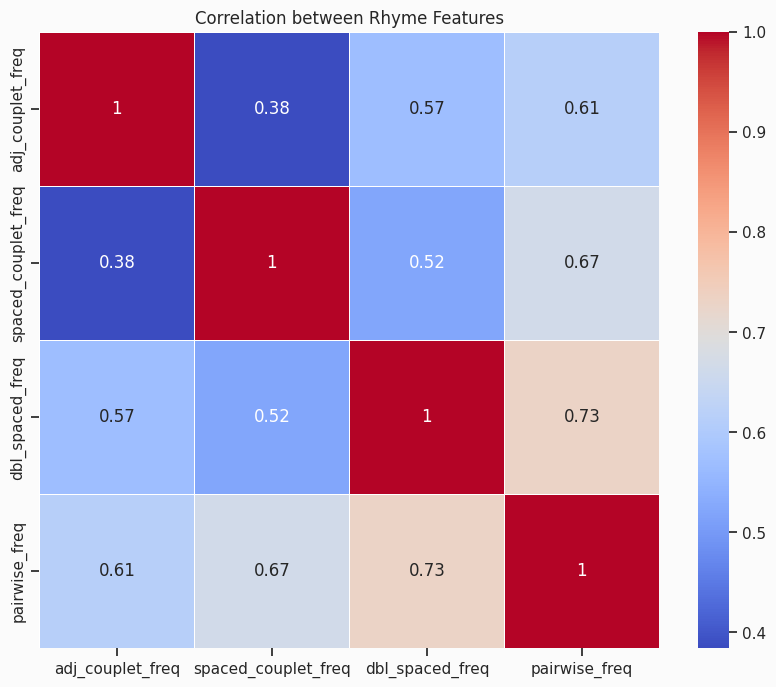

In [ ]:
columns_to_plot = ['adj_couplet_freq', 'spaced_couplet_freq', 'dbl_spaced_freq', 'pairwise_freq']
subset_df = df2[columns_to_plot]
plt.figure(figsize=(10, 8))  # Adjust the figure size as needed
sns.heatmap(subset_df.corr(), annot=True, cmap='coolwarm', linewidths=.5)
plt.title('Correlation between Rhyme Features')
plt.show()

In [ ]:
df2.groupby('tag')[columns_to_plot].mean().round(3)

adj_couplet_freq  spaced_couplet_freq  dbl_spaced_freq  pairwise_freq
tag                                                                           
country             0.166                0.134            0.072          0.100
pop                 0.181                0.162            0.098          0.105
rap                 0.180                0.117            0.075          0.056
rb                  0.197                0.176            0.118          0.113
rock                0.200                0.180            0.103          0.111

In [ ]:
df2.groupby('tag')[columns_to_plot].median().round(3)


adj_couplet_freq  spaced_couplet_freq  dbl_spaced_freq  pairwise_freq
tag                                                                           
country             0.132                0.105            0.040          0.077
pop                 0.148                0.135            0.073          0.086
rap                 0.162                0.094            0.052          0.042
rb                  0.172                0.153            0.091          0.092
rock                0.175                0.156            0.068          0.086

In [ ]:
#df2.to_csv('/content/drive/MyDrive/songs_processed.csv', index=False)

## Topic Modeling

### LDA

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
dictionary = Dictionary(df['lemm_no_stop'])

word_frequencies_before = {dictionary[idx]: freq for idx, freq in dictionary.dfs.items()}

# Perform filtering
word_number = 10
min_df = 5
max_df = 0.5

print('Before filter:\t\t', len(dictionary))
dictionary.filter_extremes(no_below=min_df)
print('Low filter:\t\t', len(dictionary))
dictionary.filter_extremes(no_above=max_df)
print('High and low filter:\t', len(dictionary))

# Compute word frequencies after filtering
word_frequencies_after = {dictionary[idx]: freq for idx, freq in dictionary.dfs.items()}

Before filter:		 26233
Low filter:		 5882
High and low filter:	 5882


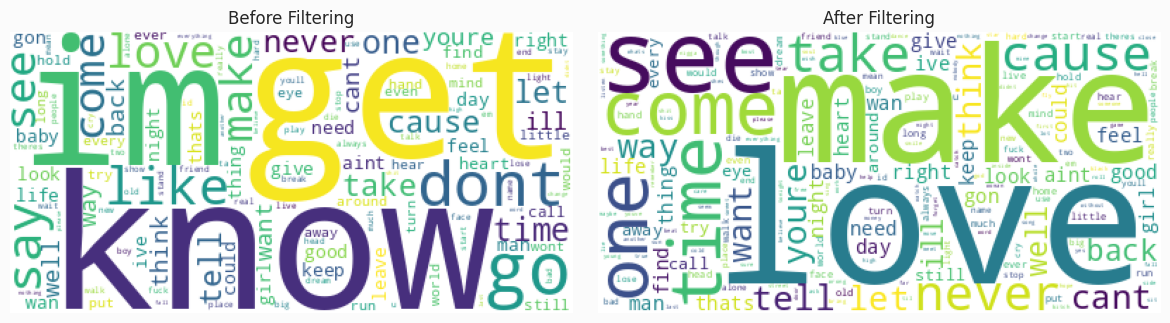

In [ ]:
# Generate word clouds
wordcloud_before = WordCloud(width=400, height=200, background_color='white', max_words=200).generate_from_frequencies(word_frequencies_before)
wordcloud_after = WordCloud(width=400, height=200, background_color='white', max_words=200).generate_from_frequencies(word_frequencies_after)

# Plot the WordCloud images side by side
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(wordcloud_before)
plt.title('Before Filtering')
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(wordcloud_after)
plt.title('After Filtering')
plt.axis("off")

plt.tight_layout(pad=1.5)
plt.show()

In [ ]:
corpus = [dictionary.doc2bow(text) for text in df['lemm_no_stop']]

#### Hyperparameter Tuning

In [ ]:
def topic_modeling(corpus, t, a, b, coherence_par, dictionary=dictionary):

  lda_model = models.LdaMulticore(corpus=corpus,
                                 id2word=dictionary,
                                 num_topics=t,
                                 random_state=42,
                                 alpha=a,
                                 eta=b,
                                 passes=10)  # You can adjust the number of passes

  if coherence_par == 'u_mass_coherence':
    coherence_metric = models.CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass').get_coherence()

  elif coherence_par == 'cv_coherence':
    coherence_metric = models.CoherenceModel(model=lda_model, texts=df['lemm_no_stop'], coherence='c_v').get_coherence()

  return coherence_metric

In [ ]:
# n_topics = [4,7, 10, 20, 30]
n_topics = [4,5,6,7]


n_alpha = [0.001, 0.005, 0.01, 0.1, 0.5]
n_beta = [0.001, 0.005, 0.01, 0.1, 0.5]


n_docs = len(corpus)

sets_corpus = [corpus]
# sets_corpus = [ClippedCorpus(corpus, int(n_docs*0.80)), corpus]

corpus_title = ['100% Corpus']
# corpus_title = ['80% Corpus', '100% Corpus']

In [ ]:
def run_topic_modeling(coherence_par,model_par, sets_corpus=sets_corpus, n_topics=n_topics, n_alpha=n_alpha, n_beta=n_beta, corpus_title=corpus_title):
    pbar = tqdm(total=(len(n_beta) * len(n_alpha) * len(n_topics) * len(corpus_title)))

    # iterate through validation corpuses
    for i, corpus in enumerate(sets_corpus):
        # generate parameter combinations using list comprehensions
        parameters = [(t, a, b) for t in n_topics for a in n_alpha for b in n_beta]

        # iterate through parameter combinations
        for t, a, b in parameters:
            # get the coherence score for the given parameters
            cv = topic_modeling(corpus=corpus, coherence_par=coherence_par, t=t, a=a, b=b)

            # store the results in the model_par dictionary
            model_par['Validation_set'].append(corpus_title[i])
            model_par['Topics'].append(t)
            model_par['Alpha'].append(a)
            model_par['Beta'].append(b)
            model_par['Coherence'].append(cv)

            pbar.update(1)

    pbar.close()


# Initialize model_par dictionary
model_par = {
    'Validation_set': [],
    'Topics': [],
    'Alpha': [],
    'Beta': [],
    'Coherence': []
}

# Run for UMass coherence
run_topic_modeling('u_mass_coherence', model_par=model_par)
results_umass = pd.DataFrame(model_par)

100%|██████████| 100/100 [2:04:14<00:00, 74.54s/it]


In [ ]:
# results_umass.to_csv('/content/drive/MyDrive/results_umass.csv', index=False)

In [ ]:
results_umass.sort_values(by='Coherence', ascending=True)

Validation_set  Topics  Alpha  Beta  Coherence
94    100% Corpus       7  0.100  0.50  -1.284850
89    100% Corpus       7  0.010  0.50  -1.284023
79    100% Corpus       7  0.001  0.50  -1.230581
84    100% Corpus       7  0.005  0.50  -1.230581
74    100% Corpus       6  0.500  0.50  -1.181248
..            ...     ...    ...   ...        ...
18    100% Corpus       4  0.100  0.10  -0.994649
17    100% Corpus       4  0.100  0.01  -0.991304
9     100% Corpus       4  0.005  0.50  -0.989713
14    100% Corpus       4  0.010  0.50  -0.989713
4     100% Corpus       4  0.001  0.50  -0.989713

[100 rows x 5 columns]

In [ ]:
# Reset model_par dictionary
model_par = {
    'Validation_set': [],
    'Topics': [],
    'Alpha': [],
    'Beta': [],
    'Coherence': []
}

# Run for CV coherence
run_topic_modeling('cv_coherence', model_par=model_par)
results_cv = pd.DataFrame(model_par)

100%|██████████| 100/100 [2:22:20<00:00, 85.40s/it]


In [ ]:
# results_cv.to_csv('/content/drive/MyDrive/results_cv.csv', index=False)

In [ ]:
results_cv.sort_values(by='Coherence', ascending=False)

Validation_set  Topics  Alpha  Beta  Coherence
18    100% Corpus       4  0.100  0.10   0.362651
3     100% Corpus       4  0.001  0.10   0.362651
17    100% Corpus       4  0.100  0.01   0.362651
8     100% Corpus       4  0.005  0.10   0.362651
13    100% Corpus       4  0.010  0.10   0.362651
..            ...     ...    ...   ...        ...
99    100% Corpus       7  0.500  0.50   0.344770
84    100% Corpus       7  0.005  0.50   0.337626
79    100% Corpus       7  0.001  0.50   0.337626
94    100% Corpus       7  0.100  0.50   0.335788
89    100% Corpus       7  0.010  0.50   0.335602

[100 rows x 5 columns]

In [ ]:
results_umass = pd.read_csv('/content/drive/MyDrive/results_umass.csv')
results_cv = pd.read_csv('/content/drive/MyDrive/results_cv.csv')

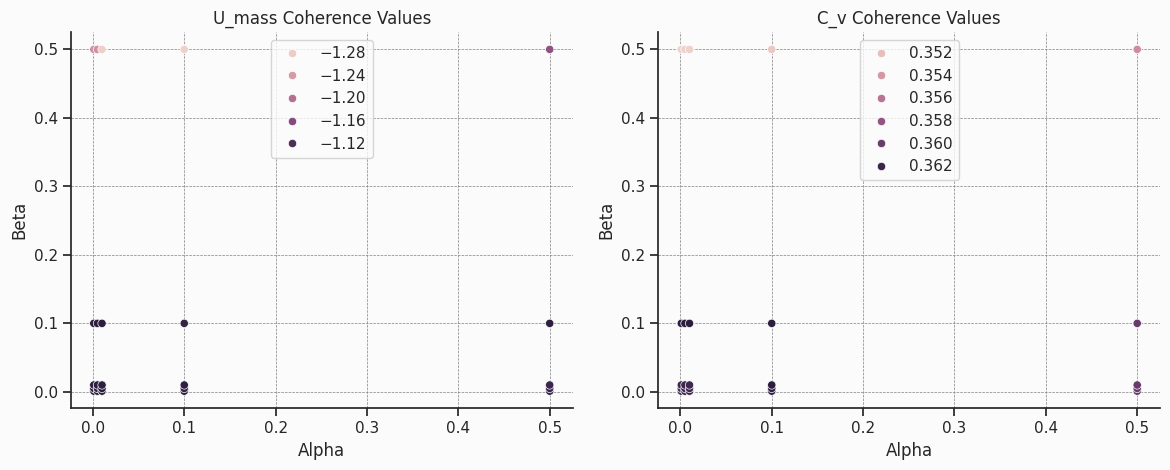

In [ ]:
data_umass = results_umass.loc[results_umass['Topics'] == 7]
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.scatterplot(data=data_umass, x='Alpha', y='Beta', hue='Coherence')
plt.legend(loc='upper center')
plt.title('U_mass Coherence Values')

# Plotting C_v Coherence Values
data_cv = results_cv.loc[results_cv['Topics'] == 4]
plt.subplot(1, 2, 2)
sns.scatterplot(data=data_cv, x='Alpha', y='Beta', hue='Coherence')
plt.legend(loc='upper center')
plt.title('C_v Coherence Values')

plt.tight_layout(pad=1.5)
plt.show()

#### LDA Model

In [ ]:
# best parameters based on u_mass
alpha = 0.100
beta = 0.50
topics = 7

In [ ]:
# Build LDA model
lda_model_umass = models.LdaMulticore(corpus=corpus,
                                 id2word=dictionary,
                                 num_topics=topics,
                                 alpha=alpha,
                                 eta=beta,
                                 random_state=42,
                                 passes=10)

# Print top 10 words of each topic
pprint(lda_model_umass.print_topics(num_topics=topics))

[(0,
  '0.039*"love" + 0.014*"time" + 0.013*"never" + 0.013*"youre" + 0.012*"make" '
  '+ 0.012*"cant" + 0.011*"one" + 0.010*"ill" + 0.009*"want" + 0.009*"need"'),
 (1,
  '0.016*"take" + 0.014*"come" + 0.010*"well" + 0.010*"away" + 0.007*"run" + '
  '0.007*"home" + 0.007*"old" + 0.007*"id" + 0.007*"time" + 0.006*"make"'),
 (2,
  '0.018*"rock" + 0.013*"man" + 0.010*"stop" + 0.010*"cause" + 0.008*"come" + '
  '0.008*"gon" + 0.008*"make" + 0.007*"night" + 0.007*"back" + 0.007*"one"'),
 (3,
  '0.030*"let" + 0.016*"wan" + 0.015*"girl" + 0.010*"see" + 0.009*"day" + '
  '0.009*"good" + 0.009*"aint" + 0.009*"want" + 0.008*"come" + 0.007*"make"'),
 (4,
  '0.052*"baby" + 0.026*"love" + 0.014*"come" + 0.011*"want" + 0.010*"give" + '
  '0.009*"youre" + 0.009*"wan" + 0.009*"babe" + 0.008*"kiss" + 0.008*"little"'),
 (5,
  '0.013*"fuck" + 0.013*"aint" + 0.012*"shit" + 0.012*"nigga" + 0.011*"bitch" '
  '+ 0.008*"cause" + 0.007*"thats" + 0.007*"see" + 0.007*"back" + '
  '0.006*"make"'),
 (6,
  '0.028*"

In [ ]:
# best parameters based on c_v
alpha = 0.100
beta = 0.10
topics = 4

In [ ]:
# Build LDA model
lda_model_cv = models.LdaMulticore(corpus=corpus,
                                 id2word=dictionary,
                                 num_topics=topics,
                                 alpha=alpha,
                                 eta=beta,
                                 random_state=42,
                                 passes=10)

# Print top 10 words of each topic
pprint(lda_model_cv.print_topics(num_topics=topics))

[(0,
  '0.041*"love" + 0.016*"youre" + 0.014*"baby" + 0.013*"time" + 0.012*"make" + '
  '0.011*"never" + 0.011*"cant" + 0.010*"one" + 0.010*"want" + 0.009*"feel"'),
 (1,
  '0.013*"take" + 0.012*"come" + 0.009*"well" + 0.008*"away" + 0.007*"day" + '
  '0.007*"make" + 0.007*"time" + 0.007*"one" + 0.006*"see" + 0.006*"run"'),
 (2,
  '0.010*"man" + 0.009*"cause" + 0.009*"fuck" + 0.009*"shit" + 0.009*"aint" + '
  '0.009*"nigga" + 0.008*"bitch" + 0.008*"rock" + 0.007*"make" + 0.007*"back"'),
 (3,
  '0.022*"baby" + 0.021*"let" + 0.018*"girl" + 0.017*"wan" + 0.016*"la" + '
  '0.013*"aint" + 0.013*"come" + 0.012*"see" + 0.011*"want" + 0.009*"make"')]


In [ ]:
lda_model = lda_model_umass

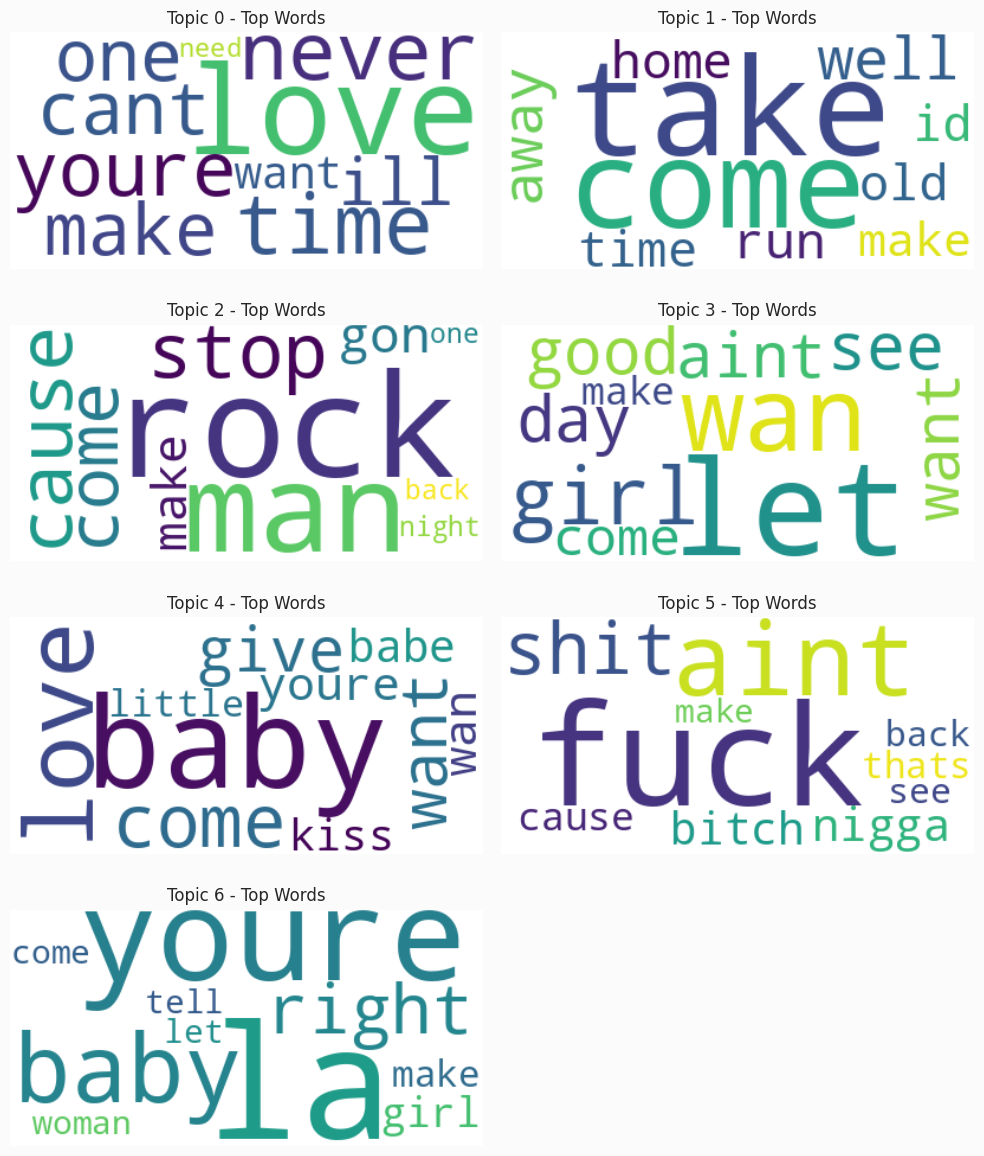

In [ ]:
topics_words = lda_model.show_topics(formatted=False, num_words=10)

# Number of rows and columns in the subplot grid
num_rows = 4
num_cols = 2

# Create a word cloud for each topic and arrange them in a grid
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 12))

# Flatten the axes array to iterate over it
axes = axes.flatten()

# Iterate over topics and plot word clouds
for i, (topic_id, words) in enumerate(topics_words):
    if i >= num_rows * num_cols:
        break  # Stop if we've filled all subplots

    wordcloud = WordCloud(width=400, height=200, background_color='white').generate_from_frequencies(dict(words))

    axes[i].imshow(wordcloud, interpolation='bilinear')
    axes[i].set_title(f'Topic {topic_id} - Top Words')
    axes[i].axis('off')

# Remove the last subplot if it's not needed
if len(topics_words) < num_rows * num_cols:
    fig.delaxes(axes[-1])

# Adjust layout
plt.tight_layout()
plt.show()

In [ ]:
lda_topic_term = pd.DataFrame(topics_words, columns=['Topic', 'other'])
lda_topic_term = lda_topic_term.explode('other')
lda_topic_term[f'Top{word_number}Word'] = lda_topic_term['other'].apply(lambda x: x[0])
lda_topic_term['Score'] = lda_topic_term['other'].apply(lambda x: x[1])
lda_topic_term.drop('other', axis=1, inplace=True)
lda_topic_term.set_index(['Topic', f'Top{word_number}Word'], inplace=True)
lda_topic_term.head(10)

Score
Topic Top10Word          
0     love       0.039361
      time       0.013569
      never      0.012971
      youre      0.012544
      make       0.011699
      cant       0.011642
      one        0.011070
      ill        0.010181
      want       0.009242
      need       0.009039

In [ ]:
lda_topic_term.reset_index(inplace=True)
lda_topic_term['test'] = list(range(0,10))*topics
lda_top_terms = pd.pivot(lda_topic_term, index='test', columns='Topic', values=f'Top{word_number}Word')
lda_top_terms.reset_index(inplace=True)
lda_top_terms.drop('test', axis=1, inplace=True)
lda_top_terms

Topic      0     1      2     3       4      5      6
0       love  take   rock   let    baby   fuck     la
1       time  come    man   wan    love   aint  youre
2      never  well   stop  girl    come   shit   baby
3      youre  away  cause   see    want  nigga  right
4       make   run   come   day    give  bitch   girl
5       cant  home    gon  good   youre  cause   make
6        one   old   make  aint     wan  thats   tell
7        ill    id  night  want    babe    see  woman
8       want  time   back  come    kiss   back   come
9       need  make    one  make  little   make    let

In [ ]:
!pip install pyLDAvis

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 45.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 45.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 346.6/346.6 kB 30.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicor

In [ ]:
import pyLDAvis
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()

In [ ]:
!pip install pandas==1.5.3

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.1/12.1 MB 33.0 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.0
    Uninstalling pandas-2.2.0:
      Successfully uninstalled pandas-2.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
pyldavis 3.4.1 requires pandas>=2.0.0, but you have pandas 1.5.3 which is incompatible.


In [ ]:
lda_viz = gensimvis.prepare(lda_model, corpus, dictionary, mds='mmds')
lda_viz

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.037507 -0.115144       1        1  30.815925
5      0.025364  0.147852       2        1  23.482826
1     -0.066599 -0.112088       3        1  16.310111
2     -0.090037  0.098266       4        1   9.592545
4      0.077742  0.021353       5        1   6.945304
6      0.137726 -0.033524       6        1   6.820702
3     -0.121704 -0.006715       7        1   6.032587, topic_info=      Term         Freq        Total Category  logprob  loglift
508   baby  4651.000000  4651.000000  Default  30.0000  30.0000
191   love  9192.000000  9192.000000  Default  29.0000  29.0000
182    let  3985.000000  3985.000000  Default  28.0000  28.0000
898     la  1171.000000  1171.000000  Default  27.0000  27.0000
531   girl  3283.000000  3283.000000  Default  26.0000  26.0000
..     ...          ...          ...      ...      ...      ...
368    way   181.684267  3216.648890   Topic7  -5.2958  -0.0658
167   keep   172.604313  2236.226476   Topic7  -5.3471   0.2465
102   feel   176.808290  2923.979777   Topic7  -5.3231   0.0024
326   take   177.715733  4218.510693   Topic7  -5.3179  -0.3591
50   cause   166.183225  4213.075104   Topic7  -5.3850  -0.4249

[555 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
4879      1  0.097141  absolutely
4879      2  0.048571  absolutely
4879      3  0.048571  absolutely
4879      5  0.048571  absolutely
4879      7  0.777130  absolutely
...     ...       ...         ...
2180      3  0.004393           ”
2180      4  0.013179           ”
2180      5  0.957662           ”
2180      6  0.004393           ”
2180      7  0.004393           ”

[2530 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 2, 3, 5, 7, 4])

In [ ]:
!pip unistall pyLDAvis
!pip install pandas==2.2.0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Using cached pandas-2.2.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (13.0 MB)
  Attempting uninstall: pandas
    Found existing installation: pandas 1.5.3
    Uninstalling pandas-1.5.3:
      Successfully uninstalled pandas-1.5.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.
bigframes 0.19.2 requires pandas<2.1.4,>=1.5.0, but you have pandas 2.2.0 which is incompatible.
google-colab 1.0.0 requires pandas==1.5.3, but you have pandas 2.2.0 which is incompatible.


In [ ]:
def format_topics_sentences(ldamodel=lda_model,
                            corpus=corpus,
                            texts=dictionary,
                            n=1):
    """
    A function for extracting a number of dominant topics for a given document
    using an existing LDA model
    """
    # Init output
    sent_topics_data = []

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            # we use range here to iterate over the n parameter
            if j in range(n):  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_data.append([int(i), int(topic_num), round(prop_topic, 4), topic_keywords])

    sent_topics_df = pd.DataFrame(sent_topics_data, columns=["Document", "Dominant_Topic", "Perc_Contribution", "Topic_Keywords"])

    return sent_topics_df


In [ ]:
topic_df = format_topics_sentences()

In [ ]:
topic_df

Document  Dominant_Topic  Perc_Contribution  \
0            0               5             0.7484   
1            1               5             0.9819   
2            2               0             0.5033   
3            3               6             0.5007   
4            4               0             0.4976   
...        ...             ...                ...   
3731      3731               0             0.3687   
3732      3732               5             0.8106   
3733      3733               0             0.6280   
3734      3734               3             0.9220   
3735      3735               5             0.6953   

                                         Topic_Keywords  
0     fuck, aint, shit, nigga, bitch, cause, thats, ...  
1     fuck, aint, shit, nigga, bitch, cause, thats, ...  
2     love, time, never, youre, make, cant, one, ill...  
3     la, youre, baby, right, girl, make, tell, woma...  
4     love, time, never, youre, make, cant, one, ill...  
...                                                 ...  
3731  love, time, never, youre, make, cant, one, ill...  
3732  fuck, aint, shit, nigga, bitch, cause, thats, ...  
3733  love, time, never, youre, make, cant, one, ill...  
3734  let, wan, girl, see, day, good, aint, want, co...  
3735  fuck, aint, shit, nigga, bitch, cause, thats, ...  

[3736 rows x 4 columns]

In [ ]:
subset_col = df[['title', 'tag', 'year', 'decade']]
df_lda = pd.concat([subset_col, topic_df], axis=1)
df_lda.head()

title  tag  year decade  Document  Dominant_Topic  \
0       Rap God  rap  2013  2010s         0               5   
1           WAP  rap  2020  2020s         1               5   
2  Shape of You  pop  2017  2010s         2               0   
3       HUMBLE.  rap  2017  2010s         3               6   
4     The Hills   rb  2015  2010s         4               0   

   Perc_Contribution                                     Topic_Keywords  
0             0.7484  fuck, aint, shit, nigga, bitch, cause, thats, ...  
1             0.9819  fuck, aint, shit, nigga, bitch, cause, thats, ...  
2             0.5033  love, time, never, youre, make, cant, one, ill...  
3             0.5007  la, youre, baby, right, girl, make, tell, woma...  
4             0.4976  love, time, never, youre, make, cant, one, ill...

In [ ]:
topic_names = {
    0: "Love_Emotions",
    1: "Journey_Exploration",
    2: "Rock_Nightlife",
    3: "Desires_Relationships",
    4: "Romantic_Gestures",
    5: "Explicit_Content",
    6: "Relationships_Feelings"
}

df_lda['mapped_topics'] = df_lda['Dominant_Topic'].map(topic_names)

In [ ]:
df_lda

title  tag  year decade  Document  Dominant_Topic  \
0               Rap God  rap  2013  2010s         0               5   
1                   WAP  rap  2020  2020s         1               5   
2          Shape of You  pop  2017  2010s         2               0   
3               HUMBLE.  rap  2017  2010s         3               6   
4             The Hills   rb  2015  2010s         4               0   
...                 ...  ...   ...    ...       ...             ...   
3731        Bahama Mama  rap  1969  1960s      3731               0   
3732               Fame  rap  1968  1960s      3732               5   
3733  Mining On my Mind  rap  1969  1960s      3733               0   
3734        Lead Single  rap  1963  1960s      3734               3   
3735        Doin Things  rap  1969  1960s      3735               5   

      Perc_Contribution                                     Topic_Keywords  \
0                0.7484  fuck, aint, shit, nigga, bitch, cause, thats, ...   
1                0.9819  fuck, aint, shit, nigga, bitch, cause, thats, ...   
2                0.5033  love, time, never, youre, make, cant, one, ill...   
3                0.5007  la, youre, baby, right, girl, make, tell, woma...   
4                0.4976  love, time, never, youre, make, cant, one, ill...   
...                 ...                                                ...   
3731             0.3687  love, time, never, youre, make, cant, one, ill...   
3732             0.8106  fuck, aint, shit, nigga, bitch, cause, thats, ...   
3733             0.6280  love, time, never, youre, make, cant, one, ill...   
3734             0.9220  let, wan, girl, see, day, good, aint, want, co...   
3735             0.6953  fuck, aint, shit, nigga, bitch, cause, thats, ...   

               mapped_topics  
0           Explicit_Content  
1           Explicit_Content  
2              Love_Emotions  
3     Relationships_Feelings  
4              Love_Emotions  
...                      ...  
3731           Love_Emotions  
3732        Explicit_Content  
3733           Love_Emotions  
3734   Desires_Relationships  
3735        Explicit_Content  

[3736 rows x 9 columns]

In [ ]:
sns.set_palette('colorblind')

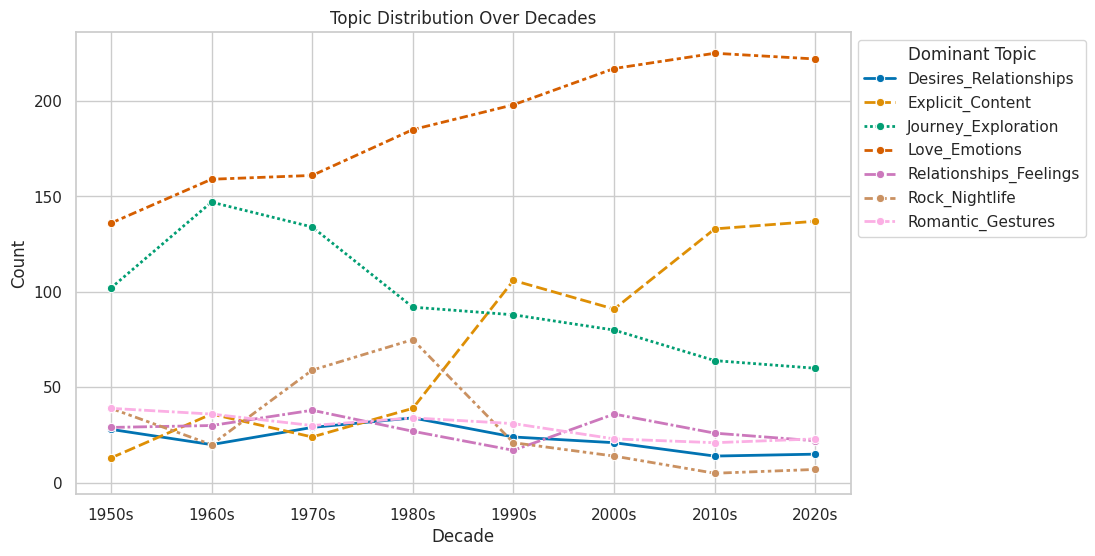

In [ ]:
topic_counts = df_lda.groupby(['decade', 'mapped_topics']).size().reset_index(name='count')

# Pivot the table to have decades as rows and topics as columns
pivot_table = topic_counts.pivot_table(index='decade', columns='mapped_topics', values='count', fill_value=0)

# Plot the line plot using matplotlib in addition to seaborn
plt.figure(figsize=(10, 6))
sns.lineplot(data=pivot_table, marker='o', linewidth=2)

# Additional matplotlib settings
plt.title('Topic Distribution Over Decades')
plt.xlabel('Decade')
plt.ylabel('Count')
plt.legend(title='Dominant Topic', bbox_to_anchor=(1, 1))

# Show the plot
plt.show()

<Figure size 1200x800 with 0 Axes>

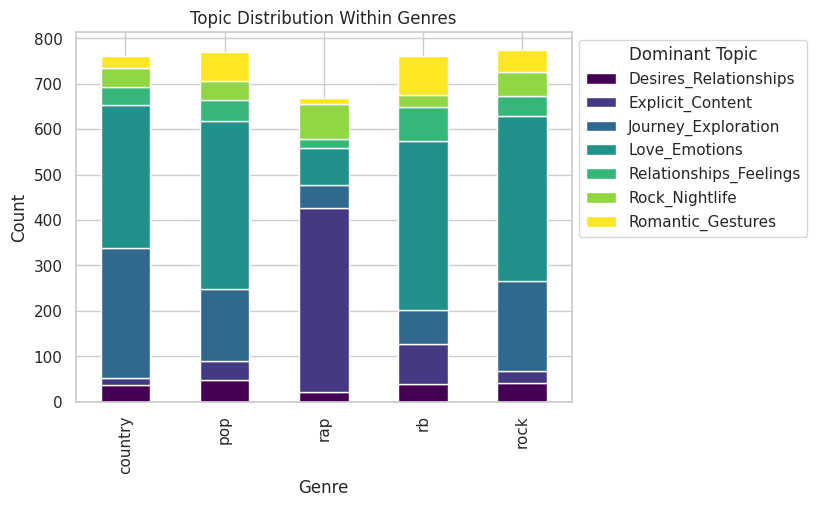

In [ ]:
topic_counts = df_lda.groupby(['tag', 'mapped_topics']).size().reset_index(name='count')

# Pivot the table to have genres as rows, topics as columns, and counts as values
pivot_table = topic_counts.pivot_table(index='tag', columns='mapped_topics', values='count', fill_value=0)

# Plot the stacked bar plot
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 8))
pivot_table.plot(kind='bar', stacked=True, cmap='viridis')
plt.title('Topic Distribution Within Genres')
plt.xlabel('Genre')
plt.ylabel('Count')
plt.legend(title='Dominant Topic', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
pivot_table

mapped_topics  Desires_Relationships  Explicit_Content  Journey_Exploration  \
tag                                                                           
country                           36                16                  286   
pop                               48                42                  159   
rap                               21               406                   50   
rb                                39                89                   73   
rock                              41                26                  199   

mapped_topics  Love_Emotions  Relationships_Feelings  Rock_Nightlife  \
tag                                                                    
country                  316                      40              41   
pop                      369                      46              42   
rap                       81                      21              77   
rb                       374                      74              26   
rock                     363                      44              54   

mapped_topics  Romantic_Gestures  
tag                               
country                       26  
pop                           64  
rap                           13  
rb                            86  
rock                          48

In [ ]:
df_lda.groupby('mapped_topics')['Perc_Contribution'].median()

mapped_topics
Desires_Relationships     0.6026
Explicit_Content          0.7246
Journey_Exploration       0.6873
Love_Emotions             0.7770
Relationships_Feelings    0.6558
Rock_Nightlife            0.6799
Romantic_Gestures         0.6735
Name: Perc_Contribution, dtype: float32

<function matplotlib.pyplot.show(close=None, block=None)>

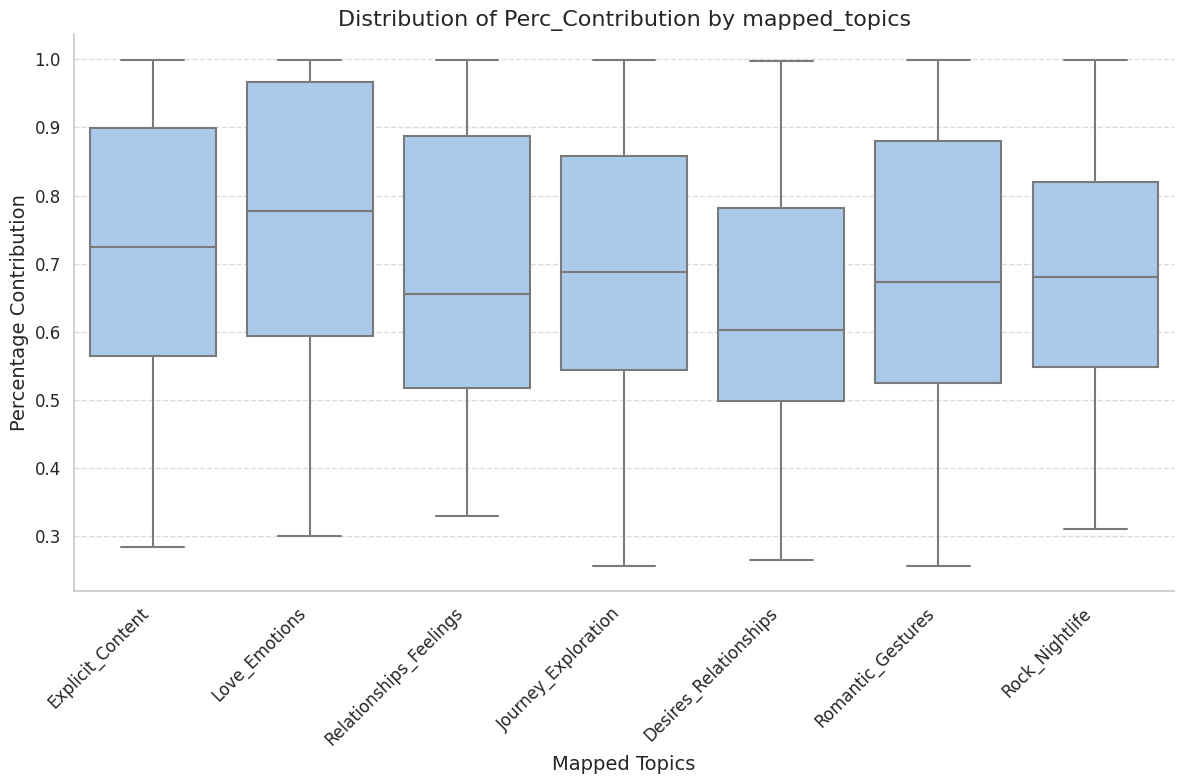

In [ ]:
sns.set_palette("pastel")

# Create the boxplot
plt.figure(figsize=(12, 8))
sns.boxplot(x='mapped_topics', y='Perc_Contribution', data=df_lda, width=0.8, linewidth=1.5)
plt.title('Distribution of Perc_Contribution by mapped_topics', fontsize=16)
plt.xlabel('Mapped Topics', fontsize=14)
plt.ylabel('Percentage Contribution', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Adding a touch of seaborn's style
sns.despine()
plt.tight_layout()
plt.show

### LSA

In [ ]:
topics = 4

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_features=1200)
documents = [' '.join(words) for words in df['lemm_no_stop']]
tfidf = tfidf_vectorizer.fit_transform(documents)

In [ ]:
tfidf.shape

(3736, 1200)

In [ ]:
U, Sigma, VT = randomized_svd(tfidf,
                              n_components=topics,
                              n_iter=7,
                              random_state=None)

print(U.shape, Sigma.shape, VT.shape)

(3736, 4) (4,) (4, 1200)


In [ ]:
terms = tfidf_vectorizer.get_feature_names_out() # list of vocaboulary values

topic_list = []
terms_list = []
score_list = []
terms_only = []

for i, comp in enumerate(VT): # svd_model.components_ is the topic-term matrix
    topic_list.extend([i]*word_number)
    terms_comp = zip(terms, list(np.around(np.array(comp), 2)))
    sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:word_number]
    terms_list.extend(list(zip(*sorted_terms))[0])
    terms_only.append(list(zip(*sorted_terms))[0])
    score_list.extend(list(zip(*sorted_terms))[1])

lsa_topic_term = pd.DataFrame(list(zip(topic_list, terms_list, score_list)), columns=['Topic', f'Top{word_number}Word', 'Score'])
lsa_topic_term.set_index(['Topic', f'Top{word_number}Word'], inplace=True)
lsa_topic_term.head(10)

Score
Topic Top10Word       
0     get         0.25
      im          0.25
      love        0.22
      dont        0.19
      know        0.19
      like        0.17
      go          0.15
      say         0.15
      baby        0.13
      youre       0.12
1     love        0.68
      baby        0.13
      heart       0.10
      true        0.07
      always      0.05
      away        0.05
      darling     0.05
      dream       0.05
      feel        0.05
      find        0.05
2     love        0.50
      baby        0.25
      nigga       0.20
      bitch       0.19
      fuck        0.18
      get         0.18
      shit        0.16
      im          0.15
      aint        0.10
      dont        0.09
3     baby        0.59
      dont        0.23
      wan         0.22
      want        0.19
      girl        0.15
      youre       0.13
      know        0.12
      let         0.12
      get         0.09
      babe        0.07

In [ ]:
lsa_top_terms = pd.DataFrame(terms_only).transpose()
lsa_top_terms

0        1      2      3
0    get     love   love   baby
1     im     baby   baby   dont
2   love    heart  nigga    wan
3   dont     true  bitch   want
4   know   always   fuck   girl
5   like     away    get  youre
6     go  darling   shit   know
7    say    dream     im    let
8   baby     feel   aint    get
9  youre     find   dont   babe